# Tohoku tsunami inversion
## 11. Inversion using discrete adjoint with 1 basis function

Let's see if we can invert for a single parameter.

We also use the mixed continuous-discontinuous discretisation used in notebook 9.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [3]:
from thetis import *
from firedrake_adjoint import *

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.unsteady.swe.tsunami.conversion import from_latlon
from adapt_utils.misc import box, ellipse, gaussian

Misc plotting routines

In [5]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [6]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [7]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

In [8]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    try:
        op.default_mesh.coordinates.at(op.gauges[gauge]['coords'])
    except PointNotInDomainError:
        op.gauges.pop(gauge)  # Some gauges aren't within the domain

mesh = op.default_mesh
P1 = FunctionSpace(mesh, "CG", 1)
mixed_space = get_functionspace(mesh, "DG", 1, vector=True)*get_functionspace(mesh, "CG", 2)
R = FunctionSpace(mesh, "R", 0)
m0 = Function(R)

boundary_conditions = {
    100: {'un': Constant(0.0), 'elev': 0},
    200: {'un': Constant(0.0)},
    300: {'un': Constant(0.0)},
}

### Forward model

As before, consider the nonlinear shallow water equations:

$$
    \frac{\partial\mathbf u}{\partial t}
    +\mathbf u\cdot\nabla\mathbf u
    +g\nabla\eta
    +f\widehat{\mathbf z}\times\mathbf u
    =\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}
    +\nabla\cdot(H\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Define fields for forward model, e.g. bathymetry from GEBCO.

In [9]:
def get_fields(fs):
    """
    Define fields associated with the physical model, as well as the gravitational acceleration constant.
      
    :arg fs: the mixed function space used to solve the forward problem. The bathymetry and the Coriolis
        parameter are taken to live in the associated elevation space.
    """
    b = Function(fs, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(fs))
    f = Function(fs, name="Coriolis parameter").assign(op.set_coriolis(fs))
    g = Constant(op.g)  # Gravitational acceleration
    gamma = Constant(0.025)  # Manning drag coefficient
    return b, f, g, gamma

In [10]:
def solve_forward(initial_condition, artificial=False, rotational=False, store_timeseries=False, ext=''):
    """
    Solve the shallow water equations for some `initial_condition`.
    """
    print("FORWARD SOLVE")
    
    # --- Setup function spaces
    
    P0 = FunctionSpace(mesh, "DG", 0)
    P1 = FunctionSpace(mesh, "CG", 1)
    
    # -- Setup fields
    
    b, f, g, gamma = get_fields(P1)
    
    # --- Setup PDE
    
    solver_obj = solver2d.FlowSolver2d(mesh, b)
    options = solver_obj.options
    options.timestep = op.dt
    options.simulation_end_time = op.end_time
    options.simulation_export_time = 48*op.dt
    options.output_directory = 'outputs/inversion'
    options.timestepper_type = 'CrankNicolson'
    options.element_family = 'dg-cg'
    options.norm_smoother = Constant(0.01)
    options.use_lax_friedrichs_velocity = True
    options.lax_friedrichs_velocity_scaling_factor = Constant(1.0)
    options.horizontal_viscosity = None
    if rotational:
        options.coriolis_frequency = f
    options.manning_drag_coefficient = gamma
    solver_obj.bnd_functions['shallow_water'] = boundary_conditions
    solver_obj.create_function_spaces()
    
    # --- Setup initial condition / control
        
    # Time integration parameters
    options.timestepper_options.implicitness_theta = 0.5  # Default for Crank-Nicolson
    options.timestepper_options.use_semi_implicit_linearization = True  # Needed due to Manning drag term
    options.timestepper_options.solver_parameters['snes_converged_reason'] = None
    options.timestepper_options.solver_parameters['ksp_converged_reason'] = None
    
    # Assign initial conditions manually to avoid splitting annotation
    if not solver_obj._initialized:
        solver_obj.initialize()
#     solver_obj.fields.solution_2d.assign(initial_condition)
    solver_obj.fields.solution_2d.project(initial_condition)
    solver_obj.timestepper.initialize(solver_obj.fields.solution_2d)
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        if artificial:
            op.gauges[gauge]['data'] = []
        elif store_timeseries:
            op.gauges[gauge]['timeseries'+ext] = []
            op.gauges[gauge]['diff'+ext] = []
            op.gauges[gauge]['timeseries_smooth'+ext] = []
            op.gauges[gauge]['diff_smooth'+ext] = []
            op.gauges[gauge]['init'+ext] = None
            op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
    times = []
    op.J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    dtc = Constant(op.dt)
    shift = Constant(0.0)
    
    def update_forcings(t):
        iteration = solver_obj.iteration
        times.append(t)
        weight.assign(0.5 if np.allclose(t, 0.0) or np.allclose(t, op.end_time) else 1.0)
        eta = solver_obj.fields.elev_2d
        for gauge in op.gauges:
            
            # Interpolate observations
            if artificial:
                obs = eta.at(op.gauges[gauge]["coords"])
                op.gauges[gauge]['data'].append(float(obs))
            else:
                obs = op.gauges[gauge]['data'][iteration] - op.gauges[gauge]['data'][0]
                eta_obs.assign(obs)
            
                if store_timeseries:

                    # Point evaluation at gauges
                    eta_discrete = eta.at(op.gauges[gauge]["coords"])
                    if np.allclose(t, 0.0):
                        op.gauges[gauge]['init'+ext] = eta_discrete
                    op.gauges[gauge]['timeseries'+ext].append(float(eta_discrete - op.gauges[gauge]['init'+ext]))

                    # Discrete form of error
                    diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
                    op.gauges[gauge]['diff'+ext].append(diff)

                # Continuous form of error
                I = op.gauges[gauge]['indicator']
                shift.assign(op.gauges[gauge]['init'+ext])
                eta_shift = eta - shift
                diff = 0.5*I*(eta_shift - eta_obs)**2
                op.J += assemble(weight*dtc*diff*dx)
                if store_timeseries:
                    A = op.gauges[gauge]['area']
                    op.gauges[gauge]['diff_smooth'+ext].append(assemble(diff*dx, annotate=False)/A)
                    op.gauges[gauge]['timeseries_smooth'+ext].append(assemble(I*eta_shift*dx, annotate=False)/A)
    
    update_forcings(0.0)
    solver_obj.iterate(update_forcings=update_forcings)
    if artificial:
        op.J = np.nan
    else:
        print("    Quantity of interest = {:.8e}".format(op.J))
    return op.J, solver_obj.fields.solution_2d

In [11]:
kernel = Function(mixed_space)
kernel_u, kernel_eta = kernel.split()
kernel_eta.interpolate(gaussian([(0.7e+06, 4.2e+06, 72e+03, 144e+03), ], mesh, rotation=pi/12));

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 765633.5351 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 624388.6768 u norm: 23482.2630  6.22
    2    96 T=    480.00 eta norm: 508398.9400 u norm: 34740.3955  5.12
    3   144 T=    720.00 eta norm: 499285.5577 u norm: 40913.3574  5.26
    4   192 T=    960.00 eta norm: 513002.7427 u norm: 48496.5228  5.30
    5   240 T=   1200.00 eta norm: 521786.3714 u norm: 58058.9416  5.27
    6   288 T=   1440.00 eta norm: 528577.8578 u norm: 67333.7249  5.29


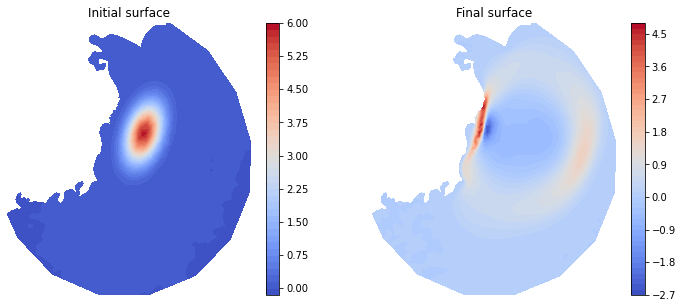

In [12]:
with stop_annotating():
    m0.assign(6.0)
    
    ic = Function(mixed_space)
    ic_uv, ic_elev = ic.split()
    ic_uv.dat.name = "Initial velocity"
    ic_elev.dat.name = "Initial surface"
    ic.project(m0*kernel)    
    J, q = solve_forward(ic, artificial=True)
    eta = q.split()[1]
    eta.dat.name = "Final surface"
    plot_fields(ic_elev, eta)

In [15]:
m0.assign(1.0)
ic.project(m0*kernel);
J, q = solve_forward(ic, store_timeseries=True)
u, eta = q.split()
u.dat.name = "Velocity (initial guess control)"
eta.dat.name = "Elevation (initial guess control)"

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 127605.5892 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 104073.2194 u norm:  3914.1105  8.14
    2    96 T=    480.00 eta norm: 84739.1003 u norm:  5791.1463  7.44
    3   144 T=    720.00 eta norm: 83220.9181 u norm:  6820.0714  7.59
    4   192 T=    960.00 eta norm: 85513.4894 u norm:  8085.0250  7.82
    5   240 T=   1200.00 eta norm: 86982.9115 u norm:  9687.8171  8.59
    6   288 T=   1440.00 eta norm: 88112.9502 u norm: 11265.1503  9.03


    Quantity of interest = 1.00586118e+13


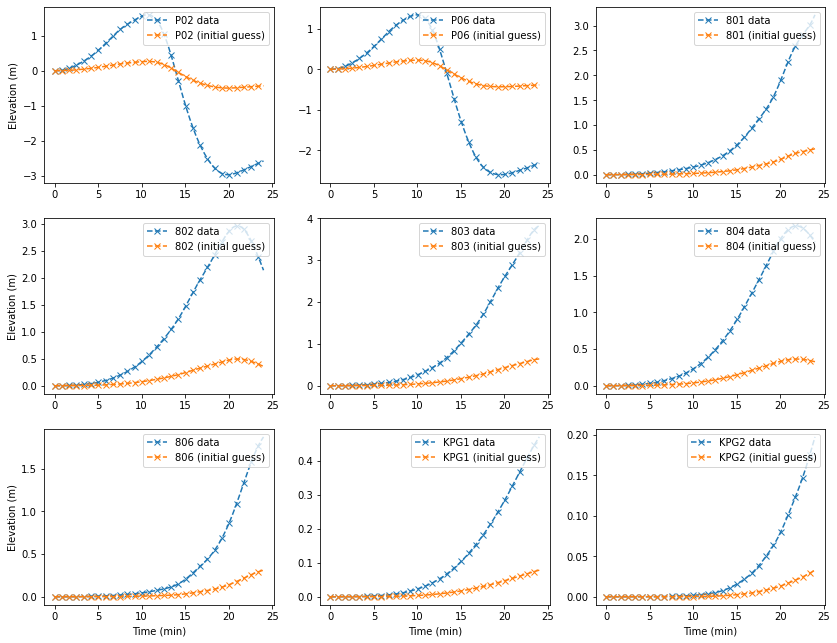

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 11))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//3, i%3]
    toplot = np.array(op.gauges[gauge]['data'][:-1]) - op.gauges[gauge]['data'][0]
    ax.plot(times/60, toplot, '--x', label=gauge + ' data', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' (initial guess)', markevery=10)
    ax.legend(loc='upper right')
    if i//3 == 2:
        ax.set_xlabel('Time (min)')
    if i%3 == 0:
        ax.set_ylabel('Elevation (m)')

## Inversion

In [17]:
opt_kwargs = {
    'maxiter': 20,
    'gtol': 1.0,
}

def eval_cb_post(j, m):
    print("functional value {:.8e}  control {:.8e}".format(j, m.dat.data[0]))

def derivative_cb_post(j, dj, m):
    print("functional value {:.8e}  control {:.8e}  norm of gradient {:.8e}".format(j, m.dat.data[0], dj.dat.data[0]))

Jhat = ReducedFunctional(J, Control(m0), eval_cb_post=eval_cb_post, derivative_cb_post=derivative_cb_post)

In [18]:
ic_opt = minimize(Jhat, method='BFGS', options=opt_kwargs)

functional value 1.00586118e+13  control 1.00000000e+00
functional value 1.00586118e+13  control -3.01554570e+12  norm of gradient 1.00000000e+00
functional value 7.47445925e+12  control 2.01000000e+00
functional value 7.47445925e+12  control -2.10144339e+12  norm of gradient 2.01000000e+00
functional value 5.03778537e+12  control 4.33190403e+00
functional value 5.03778537e+12  control 3.36072989e+09  norm of gradient 4.33190403e+00
functional value 5.03777915e+12  control 4.32819666e+00
functional value 5.03777915e+12  control -3.70432509e+06  norm of gradient 4.32819666e+00
functional value 5.03777915e+12  control 4.32820074e+00
functional value 5.03777915e+12  control -6.46078642e+00  norm of gradient 4.32820074e+00
functional value 5.03777915e+12  control 4.32820074e+00
functional value 5.03777915e+12  control -1.98149726e-03  norm of gradient 4.32820074e+00
Optimization terminated successfully.
         Current function value: 5037779146827.817383
         Iterations: 5
         F

It looks like we found a local minimum.

# [Note the controls and gradients are reported the wrong way round above]

In [20]:
ic.project(kernel*ic_opt);

In [21]:
J, q_opt = solve_forward(ic, store_timeseries=True, ext='_opt')

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 552302.6060 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 450425.4663 u norm: 16939.9038  9.49
    2    96 T=    480.00 eta norm: 366750.7105 u norm: 25062.1317  8.52
    3   144 T=    720.00 eta norm: 360177.6633 u norm: 29515.2438  9.84
    4   192 T=    960.00 eta norm: 370081.9984 u norm: 34987.0760  8.76
    5   240 T=   1200.00 eta norm: 376426.0964 u norm: 41898.1329  8.76
    6   288 T=   1440.00 eta norm: 381321.9725 u norm: 48633.6905  8.98


    Quantity of interest = 2.99772018e+12


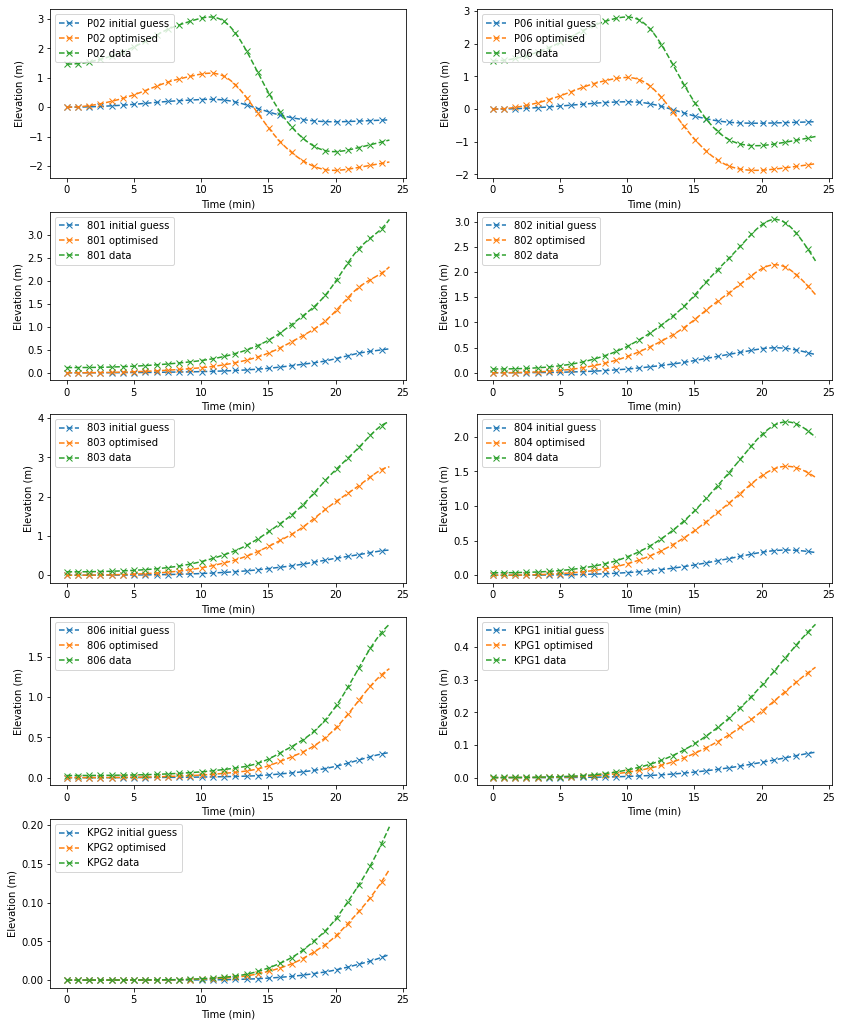

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries_opt'][:-1], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['data'][:-1], '--x', label=gauge + ' data', markevery=10)
    ax.legend(loc='upper left')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[4, 1].axis('off');

In [23]:
m0.assign(10.0)
ic.project(m0*kernel);
J, q = solve_forward(ic, store_timeseries=True)
u, eta = q.split()
u.dat.name = "Velocity (initial guess control)"
eta.dat.name = "Elevation (initial guess control)"

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 1276055.8919 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 1040580.3235 u norm: 39133.9049  9.58
    2    96 T=    480.00 eta norm: 847284.0533 u norm: 57892.0208  8.88
    3   144 T=    720.00 eta norm: 832089.2505 u norm: 68179.5225  9.19
    4   192 T=    960.00 eta norm: 854900.4454 u norm: 80809.3216  9.44
    5   240 T=   1200.00 eta norm: 869496.9133 u norm: 96675.1261 10.46
    6   288 T=   1440.00 eta norm: 880839.3996 u norm: 111889.3418  9.22


    Quantity of interest = 1.14210879e+13


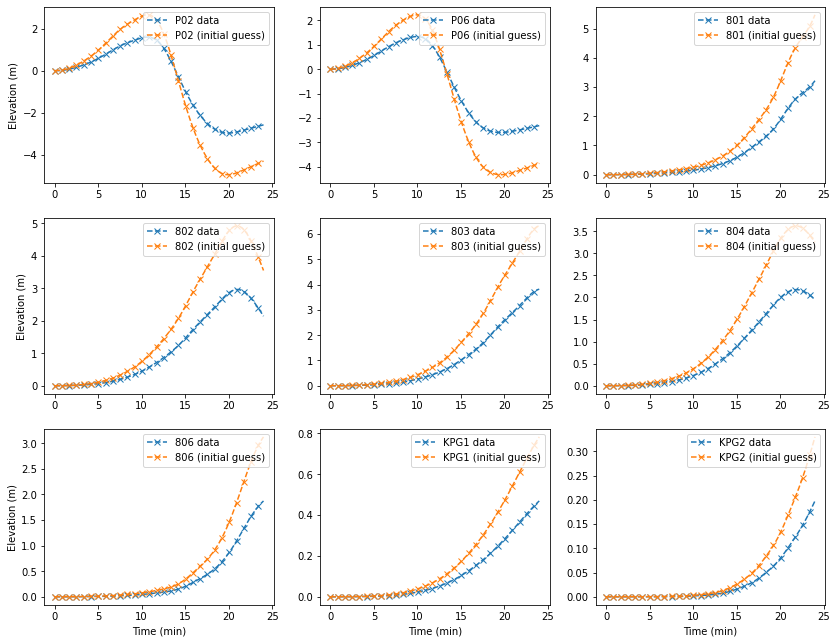

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 11))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//3, i%3]
    toplot = np.array(op.gauges[gauge]['data'][:-1]) - op.gauges[gauge]['data'][0]
    ax.plot(times/60, toplot, '--x', label=gauge + ' data', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' (initial guess)', markevery=10)
    ax.legend(loc='upper right')
    if i//3 == 2:
        ax.set_xlabel('Time (min)')
    if i%3 == 0:
        ax.set_ylabel('Elevation (m)')

## Inversion

In [25]:
opt_kwargs = {
    'maxiter': 20,
    'gtol': 1.0,
}

def eval_cb_post(j, m):
    print("functional value {:.8e}  control {:.8e}".format(j, m.dat.data[0]))

def derivative_cb_post(j, dj, m):
    print("functional value {:.8e}  control {:.8e}  norm of gradient {:.8e}".format(j, m.dat.data[0], dj.dat.data[0]))

Jhat = ReducedFunctional(J, Control(m0), eval_cb_post=eval_cb_post, derivative_cb_post=derivative_cb_post)

In [26]:
ic_opt = minimize(Jhat, method='BFGS', options=opt_kwargs)

functional value 1.14210881e+13  control 1.00000000e+01
functional value 1.14210881e+13  control 1.00000000e+01  norm of gradient 3.38469112e+12
functional value 8.46803223e+12  control 8.99000000e+00
functional value 8.46803223e+12  control 8.99000000e+00  norm of gradient 2.46308832e+12
functional value 5.17561238e+12  control 6.56817340e+00
functional value 5.17561238e+12  control 6.56817340e+00  norm of gradient 2.56689358e+11
functional value 5.13940778e+12  control 6.28642150e+00
functional value 5.13940778e+12  control 6.28642150e+00  norm of gradient 3.20216276e+08
functional value 5.13940772e+12  control 6.28606958e+00
functional value 5.13940772e+12  control 6.28606958e+00  norm of gradient 4.20085532e+04
functional value 5.13940772e+12  control 6.28606953e+00
functional value 5.13940772e+12  control 6.28606953e+00  norm of gradient 9.85161750e-03
functional value 5.13940772e+12  control 6.28606958e+00
functional value 5.13940772e+12  control 6.28606958e+00  norm of gradient 

KeyboardInterrupt: 

In [13]:
# ic.project(kernel*ic_opt);
m0.assign(6.28606958e+00)
ic.project(kernel*m0);

In [14]:
J, q_opt = solve_forward(ic, store_timeseries=True, ext='_opt')

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 802137.6124 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 654155.4104 u norm: 24601.7127  9.61
    2    96 T=    480.00 eta norm: 532636.3819 u norm: 36396.3686  7.84
    3   144 T=    720.00 eta norm: 523088.2289 u norm: 42863.6115  7.71
    4   192 T=    960.00 eta norm: 537457.1381 u norm: 50807.9338  8.04
    5   240 T=   1200.00 eta norm: 546657.6064 u norm: 60823.0390  7.64
    6   288 T=   1440.00 eta norm: 553773.7957 u norm: 70528.9190  7.74


    Quantity of interest = 2.98467858e+12


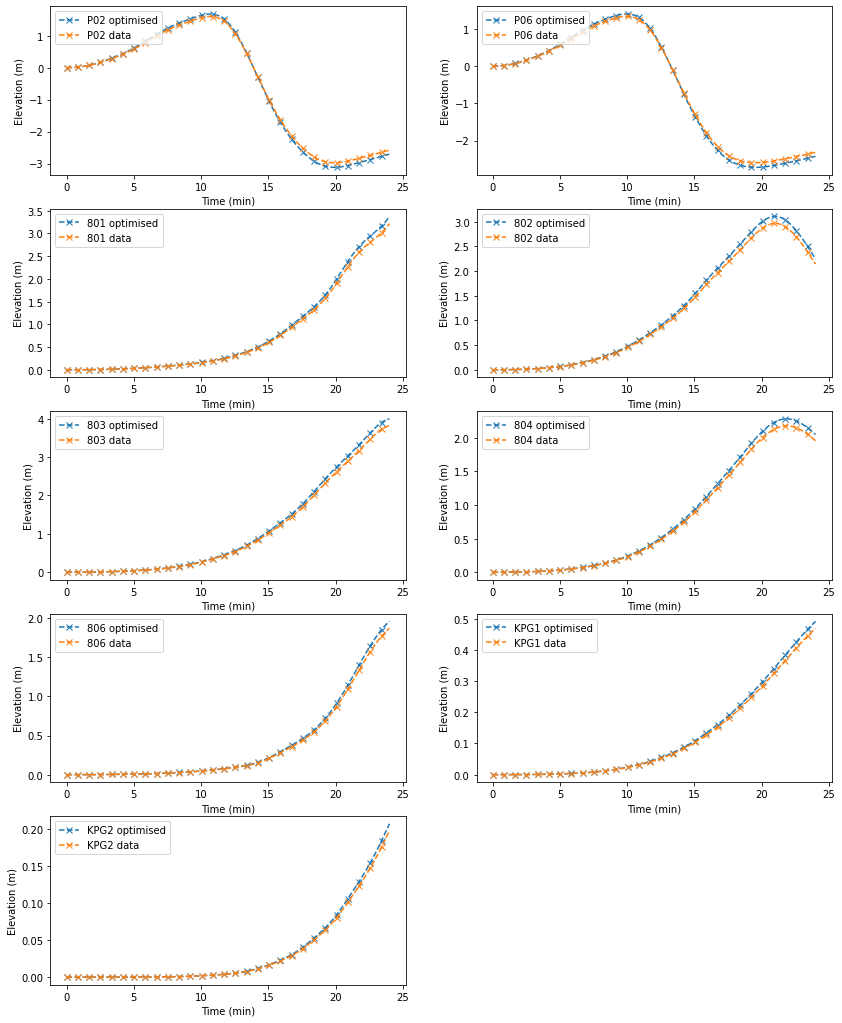

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries_opt'][:-1], '--x', label=gauge + ' optimised', markevery=10)
    toplot = np.array(op.gauges[gauge]['data'][:-1]) - op.gauges[gauge]['data'][0]
    ax.plot(times/60, toplot, '--x', label=gauge + ' data', markevery=10)
    ax.legend(loc='upper left')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[4, 1].axis('off');

In this case we were drawn right into the basin of attraction and got so close to the minimum that the line search was taking forever to backtrack.